⇢ Downloading weekly deaths dataset …
⇢ Downloading annual population dataset …
⇢ Calculating baseline and excess mortality …


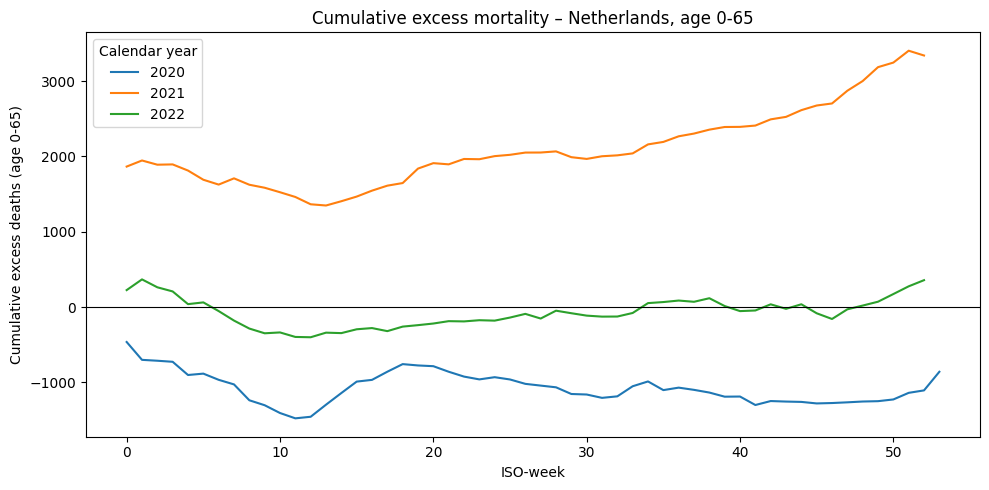

✓ Analysis complete → excess_mortality_0_65.csv saved.
✓ Alle zelftests geslaagd.


In [5]:

"""
Excess mortality analysis – Netherlands, age 0‑65
=================================================
Dit script berekent – uitsluitend met openbare CBS‑data – de cumulatieve
oversterfte voor de leeftijdsgroep 0‑65 jaar. Het download‑ en
verwerkingstraject is robuust gemaakt tegen API‑storingen en omvat een
set zelftests om stille data‑issues tijdig te vangen.

**Nieuw in deze versie**
-----------------------
* **CBS OData endpoint geactualiseerd** naar `opendata.cbs.nl`
  (oude `cbsp` hostname leverde HTML i.p.v. data en triggerde fallback).
* **OData‑calls proberen een reserve base**, pagineren (<10k rijen) en
  ondersteunen server-side filters om grote queries te vermijden.
* **Dimensie‑filters zijn robuust**: kolomnamen (Age/Leeftijd) worden
  autodetecteerd, labels worden naar dimension keys gemapt en desnoods
  wordt 0‑65 opgebouwd uit enkelvoudige leeftijden.
* **Populatie wordt samengevoegd per jaar** zodat geen dubbelcounts meer
  ontstaan bij het mergen; grafiek kan optioneel uit.
* **CSV‑fallback is defensief**: accepteert alleen CSV/ZIP, weigert HTML
  en valideert basis‑kolommen vóór verdere analyse.
"""

from __future__ import annotations

import csv
import io
import math
import re
import time
import zipfile
from urllib.parse import quote, urljoin

import pandas as pd
import requests

try:
    import matplotlib.pyplot as plt
except ModuleNotFoundError:  # matplotlib is optioneel
    plt = None

# ---------------------------------------------------------------------------
# Configuratie
# ---------------------------------------------------------------------------
TABLE_DEATHS = "70895NED"           # Weeksterfte (CBS‑StatLine)
TABLE_POP = "37325ENG"              # Bevolking 1 januari
AGE_LABELS = ("0 tot 65 jaar", "0 to 65 years")
SEX_TOTAL_LABELS = (
    "Totaal",
    "Totaal mannen en vrouwen",
    "Total",
    "Total males and females",
)
TOTAL_LABELS = ("Total", "Totaal")
BASE_YEARS = list(range(2015, 2020))  # Baseline (2015‑2019)
MAX_RETRIES = 5                      # Pogingen per HTTP‑request
TIMEOUT = 30                         # Seconden vóór timeout
SLEEP_BASE = 2.0                     # Basis voor exponentiële back‑off
ODATA_PAGE_SIZE = 9999               # StatLine eist <10k rijen per query; pagina op 9.9k

CBS_API_BASES = (
    "https://opendata.cbs.nl/ODataApi/OData/",
    "https://opendata.cbs.nl/ODataApi/odata/",  # backup‑pad op dezelfde host
)
HEADERS = {"Accept": "application/json"}
CSV_HEADERS = {"Accept": "text/csv,application/zip;q=0.9,*/*;q=0.1"}
CBS_CSV_DL = "https://opendata.cbs.nl/download/"  # + {table_id}?type=csv
ENABLE_CSV_FALLBACK = True
ENABLE_PLOT = True  # zet op True om matplotlib-plot te tonen

# ---------------------------------------------------------------------------
# 0. Hulpfuncties
# ---------------------------------------------------------------------------

def robust_get(url: str, attempt: int = 1, headers: dict[str, str] | None = None) -> requests.Response:
    """GET met retries en exponentiële back‑off; geeft `requests.Response`."""
    try:
        resp = requests.get(url, headers=headers or HEADERS, timeout=TIMEOUT)
        resp.raise_for_status()
        return resp
    except requests.RequestException as exc:
        if attempt >= MAX_RETRIES:
            raise RuntimeError(
                f"Mislukte download na {MAX_RETRIES} pogingen: {url}"
            ) from exc
        sleep_for = SLEEP_BASE * math.pow(1.5, attempt)
        print(f"⚠️  poging {attempt} mislukt; opnieuw over {sleep_for:.1f}s …")
        time.sleep(sleep_for)
        return robust_get(url, attempt + 1, headers=headers)


def detect_column(df: pd.DataFrame, candidates: tuple[str, ...]) -> str:
    """Vind een kolomnaam uit `candidates` (case‑insensitive)."""
    for cand in candidates:
        col = next((c for c in df.columns if c.lower() == cand.lower()), None)
        if col:
            return col
    raise KeyError(
        f"Geen van de kolommen {candidates} gevonden. Beschikbaar: {list(df.columns)}"
    )


def fetch_dimension_values(table_id: str, dim_name: str) -> list[dict]:
    """Haal alle dimensionwaarden op (met fallback naar tweede base)."""
    last_error: Exception | None = None
    for base in CBS_API_BASES:
        url = urljoin(base, f"{table_id}/{dim_name}?$format=json&$top=5000")
        try:
            payload = robust_get(url, headers=HEADERS).json()
            return payload.get("value", [])
        except Exception as exc:  # pragma: no cover - netwerk/timeout
            last_error = exc
            continue
    raise RuntimeError(
        f"Dimension lookup voor {dim_name} faalde na alle bases ({last_error})."
    )


def resolve_dim_key(
    table_id: str, dim_name: str, labels: tuple[str, ...], *, values: list[dict] | None = None
) -> str:
    """Match een dimension Title/Key tegen mogelijke labels en retourneer de Key."""
    if isinstance(labels, str):
        labels = (labels,)
    values = values or fetch_dimension_values(table_id, dim_name)

    def digits_only(text: str) -> str:
        return "".join(ch for ch in text if ch.isdigit())

    for label in labels:
        label_lower = label.lower()
        label_digits = digits_only(label)

        for row in values:
            title = str(row.get("Title", ""))
            key = str(row.get("Key", ""))
            if title.lower() == label_lower or key == label:
                return key

        if label_digits:
            for row in values:
                if digits_only(str(row.get("Title", ""))) == label_digits:
                    return str(row.get("Key", ""))

    available = [row.get("Title") or row.get("Key") for row in values]
    raise KeyError(
        f"Label {labels} niet gevonden in {table_id}/{dim_name}. Beschikbaar: {available}"
    )


def resolve_age_keys(
    table_id: str,
    dim_name: str,
    labels: tuple[str, ...],
    *,
    upper_age_exclusive: int = 65,
) -> list[str]:
    """Zoek age-key(s); val terug op som van enkelvoudige leeftijden < upper_age_exclusive."""
    values = fetch_dimension_values(table_id, dim_name)
    try:
        return [resolve_dim_key(table_id, dim_name, labels, values=values)]
    except KeyError:
        age_keys: list[str] = []
        for row in values:
            title = str(row.get("Title", ""))
            if " to " in title or " tot " in title or "and older" in title.lower():
                continue  # sla aggregaties over om dubbeltellingen te voorkomen
            match = re.match(r"^(\d+)", title)
            if match and int(match.group(1)) < upper_age_exclusive:
                age_keys.append(str(row.get("Key", "")))
        if age_keys:
            return age_keys
        available = [row.get("Title") or row.get("Key") for row in values]
        raise KeyError(
            f"Geen age-keys <{upper_age_exclusive} gevonden voor {table_id}/{dim_name}. Beschikbaar: {available}"
        )


def _fetch_via_odata(table_id: str, base_url: str, *, filter_expr: str | None = None) -> pd.DataFrame:
    """Download de volledige tabel via één OData‑base URL."""
    records: list[dict] = []
    skip = 0
    filter_suffix = f"&$filter={quote(filter_expr)}" if filter_expr else ""
    url: str | None = urljoin(
        base_url, f"{table_id}/TypedDataSet?$format=json&$top={ODATA_PAGE_SIZE}{filter_suffix}"
    )
    while url:
        payload = robust_get(url, headers=HEADERS).json()
        batch = payload.get("value", [])
        records.extend(batch)
        next_link = payload.get("@odata.nextLink")
        if next_link:
            url = next_link
            continue
        if len(batch) < ODATA_PAGE_SIZE:
            break
        skip += ODATA_PAGE_SIZE
        url = urljoin(
            base_url,
            f"{table_id}/TypedDataSet?$format=json&$top={ODATA_PAGE_SIZE}&$skip={skip}{filter_suffix}",
        )
    if not records:
        raise ValueError("OData‑feed leeg")
    return pd.DataFrame.from_records(records)


def fetch_odata_dataset(table_id: str, *, filter_expr: str | None = None) -> pd.DataFrame:
    """Download alle rijen via OData; val optioneel terug op CSV bij hard error."""
    errors: list[str] = []
    for base in CBS_API_BASES:
        try:
            return _fetch_via_odata(table_id, base, filter_expr=filter_expr)
        except Exception as exc:
            msg = f"{base} → {exc}"
            errors.append(msg)
            print(f"⚠️  OData via {base} faalde: {exc}")
    if not ENABLE_CSV_FALLBACK:
        raise RuntimeError(
            "Alle OData-pogingen faalden en CSV-fallback staat uit.\n" + "\n".join(errors)
        )
    print("⚠️  Alle OData-pogingen faalden. Probeer CSV-fallback…")
    return fetch_csv_dataset(table_id, errors)


def fetch_csv_dataset(table_id: str, odata_errors: list[str] | None = None) -> pd.DataFrame:
    url = f"{CBS_CSV_DL}{table_id}?type=csv"
    resp = robust_get(url, headers=CSV_HEADERS)

    content_type = resp.headers.get("Content-Type", "").lower()
    if "html" in content_type:
        raise RuntimeError(
            f"CSV-fallback voor {table_id} gestopt: endpoint retourneert HTML ({content_type}). "
            f"OData-fouten: {odata_errors or 'n.v.t.'}"
        )
    if content_type and not any(token in content_type for token in ("csv", "zip", "octet-stream")):
        raise RuntimeError(
            f"CSV-fallback voor {table_id} gestopt: onverwachte Content-Type '{content_type}'."
        )

    df = None
    try:
        with zipfile.ZipFile(io.BytesIO(resp.content)) as zf:
            fname = zf.namelist()[0]
            with zf.open(fname) as f:
                df = pd.read_csv(f, low_memory=False)
    except zipfile.BadZipFile:
        print("⚠️  Geen ZIP gevonden, CSV rechtstreeks parsen…")
        text = resp.text
        if text.lstrip().startswith("<"):
            raise RuntimeError(
                f"CSV-fallback voor {table_id} gestopt: inhoud lijkt HTML i.p.v. CSV.\n"
                f"Eerste regels: {text[:200]!r}"
            )

        sample = text[:2048]
        seps = [",", ";", "\t"]
        try:
            dialect = csv.Sniffer().sniff(sample, delimiters=seps)
            if dialect.delimiter not in seps:
                seps.insert(0, dialect.delimiter)
        except csv.Error:
            print("⚠️  Kan delimiter niet bepalen via Sniffer")

        for sep in seps:
            try:
                df = pd.read_csv(io.StringIO(text), sep=sep, engine="python")
                print(f"✅  CSV geparsed met sep='{sep}'")
                break
            except pd.errors.ParserError:
                print(f"⚠️  ParserError met sep='{sep}', volgende…")
    if df is None or df.empty:
        raise RuntimeError(f"CSV-fallback voor {table_id} is leeg of mislukte.")
    if "Periods" not in df.columns and "Perioden" not in df.columns:
        raise RuntimeError(
            f"CSV-fallback voor {table_id} gaf onverwachte kolommen ({list(df.columns)[:10]}...). "
            "Respons lijkt geen StatLine-dataset te zijn."
        )

    return df


def detect_value_column(df: pd.DataFrame, stems: tuple[str, ...]) -> str:
    """Zoek kolom die exact overeenkomt met één van de stems, of val terug op de root."""
    for stem in stems:
        col = next((c for c in df.columns if c.lower() == stem.lower()), None)
        if col:
            return col
        col0 = next(
            (c for c in df.columns if c.lower() == stem.lower().replace("_1", "_0")),
            None,
        )
        if col0:
            return col0
    for stem in stems:
        root = stem.split("_", 1)[0]
        col_root = next((c for c in df.columns if c.lower() == root.lower()), None)
        if col_root:
            return col_root
    raise KeyError(
        f"Geen van de kolommen {stems} gevonden in dataset. "
        f"Beschikbare kolommen: {list(df.columns)}"
    )

# ---------------------------------------------------------------------------
# 1. Weeksterfte ophalen en lokaal filteren
# ---------------------------------------------------------------------------
print("⇢ Downloading weekly deaths dataset …")
df_deaths_raw = fetch_odata_dataset(TABLE_DEATHS)

DEATHS_COL = detect_value_column(df_deaths_raw, ("Deaths_1", "Overledenen_1"))
AGE_COL_DEATHS = detect_column(df_deaths_raw, ("Age", "Agegroup", "LeeftijdOp31December", "Leeftijd"))
PERIOD_COL_DEATHS = detect_column(df_deaths_raw, ("Perioden", "Periods"))
AGE_KEYS_DEATHS = resolve_age_keys(TABLE_DEATHS, AGE_COL_DEATHS, AGE_LABELS)

df_deaths = (
    df_deaths_raw[df_deaths_raw[AGE_COL_DEATHS].isin(AGE_KEYS_DEATHS)]
    .rename(columns={DEATHS_COL: "Deaths"})
    .assign(
        Year=lambda x: x[PERIOD_COL_DEATHS].astype(str).str[:4].astype(int),
        Week=lambda x: x[PERIOD_COL_DEATHS].astype(str).str[-2:].astype(int),
    )
    .groupby(["Year", "Week"], as_index=False)["Deaths"].sum()
)
assert not df_deaths.empty, "Gefilterde sterftedataset is leeg."  # test 1

# ---------------------------------------------------------------------------
# 2. Bevolkingscijfers ophalen en lokaal filteren
# ---------------------------------------------------------------------------
print("⇢ Downloading annual population dataset …")
AGE_COL_POP = "Age"
SEX_COL_POP = "Sex"
MARITAL_COL_POP = "MaritalStatus"
GEN_COL_POP = "Generation"
MIG_COL_POP = "MigrationBackground"

AGE_KEYS_POP = resolve_age_keys(TABLE_POP, AGE_COL_POP, AGE_LABELS)
SEX_KEY_POP = resolve_dim_key(TABLE_POP, SEX_COL_POP, SEX_TOTAL_LABELS)
MARITAL_KEY_POP = resolve_dim_key(TABLE_POP, MARITAL_COL_POP, TOTAL_LABELS)
GEN_KEY_POP = resolve_dim_key(TABLE_POP, GEN_COL_POP, TOTAL_LABELS)
MIG_KEY_POP = resolve_dim_key(TABLE_POP, MIG_COL_POP, TOTAL_LABELS)

age_filter = " or ".join([f"{AGE_COL_POP} eq '{k}'" for k in AGE_KEYS_POP])
pop_filter = " and ".join(
    [
        f"({age_filter})",
        f"{SEX_COL_POP} eq '{SEX_KEY_POP}'",
        f"{MARITAL_COL_POP} eq '{MARITAL_KEY_POP}'",
        f"{GEN_COL_POP} eq '{GEN_KEY_POP}'",
        f"{MIG_COL_POP} eq '{MIG_KEY_POP}'",
    ]
)

df_pop_raw = fetch_odata_dataset(TABLE_POP, filter_expr=pop_filter)

POP_COL = detect_value_column(df_pop_raw, ("Population_1", "Bevolking_1"))
PERIOD_COL_POP = detect_column(df_pop_raw, ("Periods", "Perioden"))

df_pop = (
    df_pop_raw
    .rename(columns={POP_COL: "Population"})
    .assign(Year=lambda x: x[PERIOD_COL_POP].astype(str).str[:4].astype(int))
    .groupby("Year", as_index=False)["Population"].sum()
)
assert not df_pop.empty, "Gefilterde bevolkingsdataset is leeg."  # test 2

# Zorg dat sterftejaren aansluiten op beschikbare populatiejaren
valid_years = set(df_pop["Year"].unique())
df_deaths = df_deaths[df_deaths["Year"].isin(valid_years)]
assert not df_deaths.empty, "Sterftedata bevatten geen jaren die in population voorkomen."

# ---------------------------------------------------------------------------
# 3. Baseline en oversterfte berekenen
# ---------------------------------------------------------------------------
print("⇢ Calculating baseline and excess mortality …")

df = df_deaths.merge(df_pop, on="Year", how="left")
missing_pop = df["Population"].isna().sum()
assert missing_pop == 0, f"{missing_pop} sterfterijen missen population."  # test 3

df_base = df[df["Year"].isin(BASE_YEARS)].copy()
df_base["Rate"] = df_base["Deaths"] / df_base["Population"]

baseline_week = (
    df_base.groupby("Week", as_index=False)["Rate"].mean().rename(columns={"Rate": "BaselineRate"})
)
assert baseline_week.shape[0] >= 52, "Baseline bevat minder dan 52 weken."  # test 4

df = df.merge(baseline_week, on="Week", how="left")
df["Expected"] = df["BaselineRate"] * df["Population"]
df["Excess"] = df["Deaths"] - df["Expected"]

df.sort_values(["Year", "Week"], inplace=True)
df["CumulativeExcess"] = df.groupby("Year")["Excess"].cumsum()

assert not df["Expected"].isna().any(), "Expected bevat NaN – baseline ontbreekt."  # test 5

# ---------------------------------------------------------------------------
# 4. (Optionele) visualisatie
# ---------------------------------------------------------------------------
if plt is not None and ENABLE_PLOT:
    fig, ax = plt.subplots(figsize=(10, 5))
    for year, grp in df[df["Year"] >= 2020].groupby("Year"):
        ax.plot(grp["Week"], grp["CumulativeExcess"], label=year)
    ax.set_xlabel("ISO‑week")
    ax.set_ylabel("Cumulative excess deaths (age 0‑65)")
    ax.set_title("Cumulative excess mortality – Netherlands, age 0‑65")
    ax.axhline(0, color="black", linewidth=0.8)
    ax.legend(title="Calendar year")
    fig.tight_layout()
    plt.show()
else:
    print("⚠️  matplotlib not available; plot skipped.")

# ---------------------------------------------------------------------------
# 5. Export resultaten
# ---------------------------------------------------------------------------
OUT_CSV = "excess_mortality_0_65.csv"
df.to_csv(OUT_CSV, index=False)
print(f"✓ Analysis complete → {OUT_CSV} saved.")

# ---------------------------------------------------------------------------
# 6. Zelftests / regressietests
# ---------------------------------------------------------------------------
# Test 6: eerste cumulatieve waarde van elk jaar moet gelijk zijn aan de
#         excess‑waarde van die week (geen offset in cumsum).
for yr in df["Year"].unique():
    first_week = df[(df["Year"] == yr) & (df["Week"] == df[df["Year"] == yr]["Week"].min())]
    assert abs(first_week["CumulativeExcess"].iloc[0] - first_week["Excess"].iloc[0]) < 1e-6, (
        f"Cumulatie start niet correct voor jaar {yr}."
    )
print("✓ Alle zelftests geslaagd.")


In [20]:
df_totals = (
    df_deaths.groupby("Year")["Deaths"]
    .sum()
    .rename("Deaths")
    .to_frame()
)
print(df_totals.loc[2020:2022])


       Deaths
Year         
2020  86732.0
2021  90648.0
2022  87960.0
